# **Initial Load**

Authenticate with Google Drive and read in our dataset.

In [1]:
# Install any required packages.
!pip install -U -q PyDrive

In [2]:
# Import any required libraries.
from google.colab import auth
from patsy import dmatrices
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from oauth2client.client import GoogleCredentials

In [3]:
# Authenticate with Google Drive.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [5]:
#libraries import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import train_test_split
from sklearn.model_selection import validation_curve
from sklearn.model_selection import GridSearchCV

from sklearn.neighbors import KNeighborsClassifier


from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [6]:
# Download our dataset from Google Drive.
downloaded_file = drive.CreateFile({ 'id': '14RMV7CRXwwCt_9iLHenyQrB9GC5gYwul' })
downloaded_file.GetContentFile('ChicagoCrimeRecords.csv')
chicago_crime_records = pd.read_csv('ChicagoCrimeRecords.csv')

### Pre-Processing the data

In [7]:
# Drop any NANs before we begin.
chicago_crime_records.dropna(inplace = True)

In [8]:
#Drop duplicates if there are any
chicago_crime_records.drop_duplicates(inplace=True)

In [9]:
# Take a look at all of the columns in our dataset.
chicago_crime_records.columns.sort_values()

Index(['Arrest', 'Beat', 'Block', 'Case Number', 'Community Area', 'Date',
       'Description', 'District', 'Domestic', 'FBI Code', 'ID', 'IUCR',
       'Latitude', 'Location', 'Location Description', 'Longitude',
       'Primary Type', 'Updated On', 'Ward', 'X Coordinate', 'Y Coordinate',
       'Year'],
      dtype='object')

In [10]:
chicago_crime_records.dtypes

ID                        int64
Case Number              object
Date                     object
Block                    object
IUCR                     object
Primary Type             object
Description              object
Location Description     object
Arrest                     bool
Domestic                   bool
Beat                      int64
District                float64
Ward                    float64
Community Area          float64
FBI Code                 object
X Coordinate            float64
Y Coordinate            float64
Year                      int64
Updated On               object
Latitude                float64
Longitude               float64
Location                 object
dtype: object

In [11]:
# Remove any columns that we are confident will not be of any use to our model.
chicago_crime_records.drop(
    columns = ['Case Number', 'Date', 'Description', 'ID', 'Updated On', 'Year'],
    axis = 1,
    inplace = True,
    errors = 'ignore')

In [12]:
# Take a look at all of the columns left in our dataset.
chicago_crime_records.columns.sort_values()

Index(['Arrest', 'Beat', 'Block', 'Community Area', 'District', 'Domestic',
       'FBI Code', 'IUCR', 'Latitude', 'Location', 'Location Description',
       'Longitude', 'Primary Type', 'Ward', 'X Coordinate', 'Y Coordinate'],
      dtype='object')

In [13]:
#Encoding our columns
chicago_crime_records['Arrest'] = chicago_crime_records['Arrest'].astype(int)
chicago_crime_records['Domestic'] = chicago_crime_records['Domestic'].astype(int)

chicago_crime_records['Location Description_CODE'] = chicago_crime_records['Location Description'].astype('category').cat.codes

chicago_crime_records['Block_CODE']=chicago_crime_records['Block'].astype('category').cat.codes

chicago_crime_records['Community Area']=chicago_crime_records['Community Area'].astype(int)
chicago_crime_records['District']=chicago_crime_records['District'].astype(int)

chicago_crime_records['FBI Code_CODE']=chicago_crime_records['FBI Code'].astype('category').cat.codes
chicago_crime_records['IUCR_CODE']=chicago_crime_records['IUCR'].astype('category').cat.codes


In [14]:
df_ccr=chicago_crime_records.drop(columns=['Location Description','Block','FBI Code','IUCR','Location'])

In [15]:
# Generate a correlation matrix, based on certain variables in our dataset.
correlation_matrix = df_ccr.corr()

correlation_matrix.style.background_gradient(cmap = 'coolwarm')

,Arrest,Domestic,Beat,District,Ward,Community Area,X Coordinate,Y Coordinate,Latitude,Longitude,Location Description_CODE,Block_CODE,FBI Code_CODE,IUCR_CODE
Arrest,1.000000,-0.066235,-0.016198,-0.017352,-0.016714,-0.001922,-0.033629,-0.002573,-0.002430,-0.034045,0.035045,-0.034870,0.378555,0.349849
Domestic,-0.066235,1.000000,-0.047260,-0.043854,-0.055748,0.078146,0.008897,-0.083776,-0.083596,0.007682,-0.172031,0.073398,0.007325,-0.092264
Beat,-0.016198,-0.047260,1.000000,0.950927,0.642197,-0.500825,-0.494224,0.619949,0.620329,-0.490929,0.018051,-0.121769,-0.006610,0.005037
District,-0.017352,-0.043854,0.950927,1.000000,0.685694,-0.495310,-0.539124,0.626883,0.627425,-0.536289,0.021771,-0.111947,-0.006645,0.005265
Ward,-0.016714,-0.055748,0.642197,0.685694,1.000000,-0.529669,-0.446153,0.635914,0.636052,-0.442025,-0.001518,-0.161502,-0.016912,0.000248
Community Area,-0.001922,0.078146,-0.500825,-0.495310,-0.529669,1.000000,0.252316,-0.755958,-0.755013,0.244080,0.018950,0.385655,0.017937,0.002865
X Coordinate,-0.033629,0.008897,-0.494224,-0.539124,-0.446153,0.252316,1.000000,-0.458238,-0.460126,0.999827,-0.023466,0.093541,-0.045024,-0.055027
Y Coordinate,-0.002573,-0.083776,0.619949,0.626883,0.635914,-0.755958,-0.458238,1.000000,0.999994,-0.453463,-0.039160,-0.349998,-0.012186,0.003717
Latitude,-0.002430,-0.083596,0.620329,0.627425,0.636052,-0.755013,-0.460126,0.999994,1.000000,-0.455406,-0.038949,-0.349510,-0.011984,0.003921
Longitude,-0.034045,0.007682,-0.490929,-0.536289,-0.442025,0.244080,0.999827,-0.453463,-0.455406,1.000000,-0.024287,0.089076,-0.045797,-0.055685


In [16]:
#Dropping more columns that might be unnecessary
df_ccr=df_ccr.drop(columns=['X Coordinate', 'Y Coordinate','District'])

In [17]:
#Splitting the data
X=df_ccr.drop(columns='Primary Type')
Y=df_ccr['Primary Type']
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.2,random_state=117)

In [18]:
#training the model 1st try
Knnmodel=KNeighborsClassifier()
Knnmodel.fit(x_train,y_train)
y_pred=Knnmodel.predict(x_test)
print(accuracy_score(y_test,y_pred))


0.9319556498234375


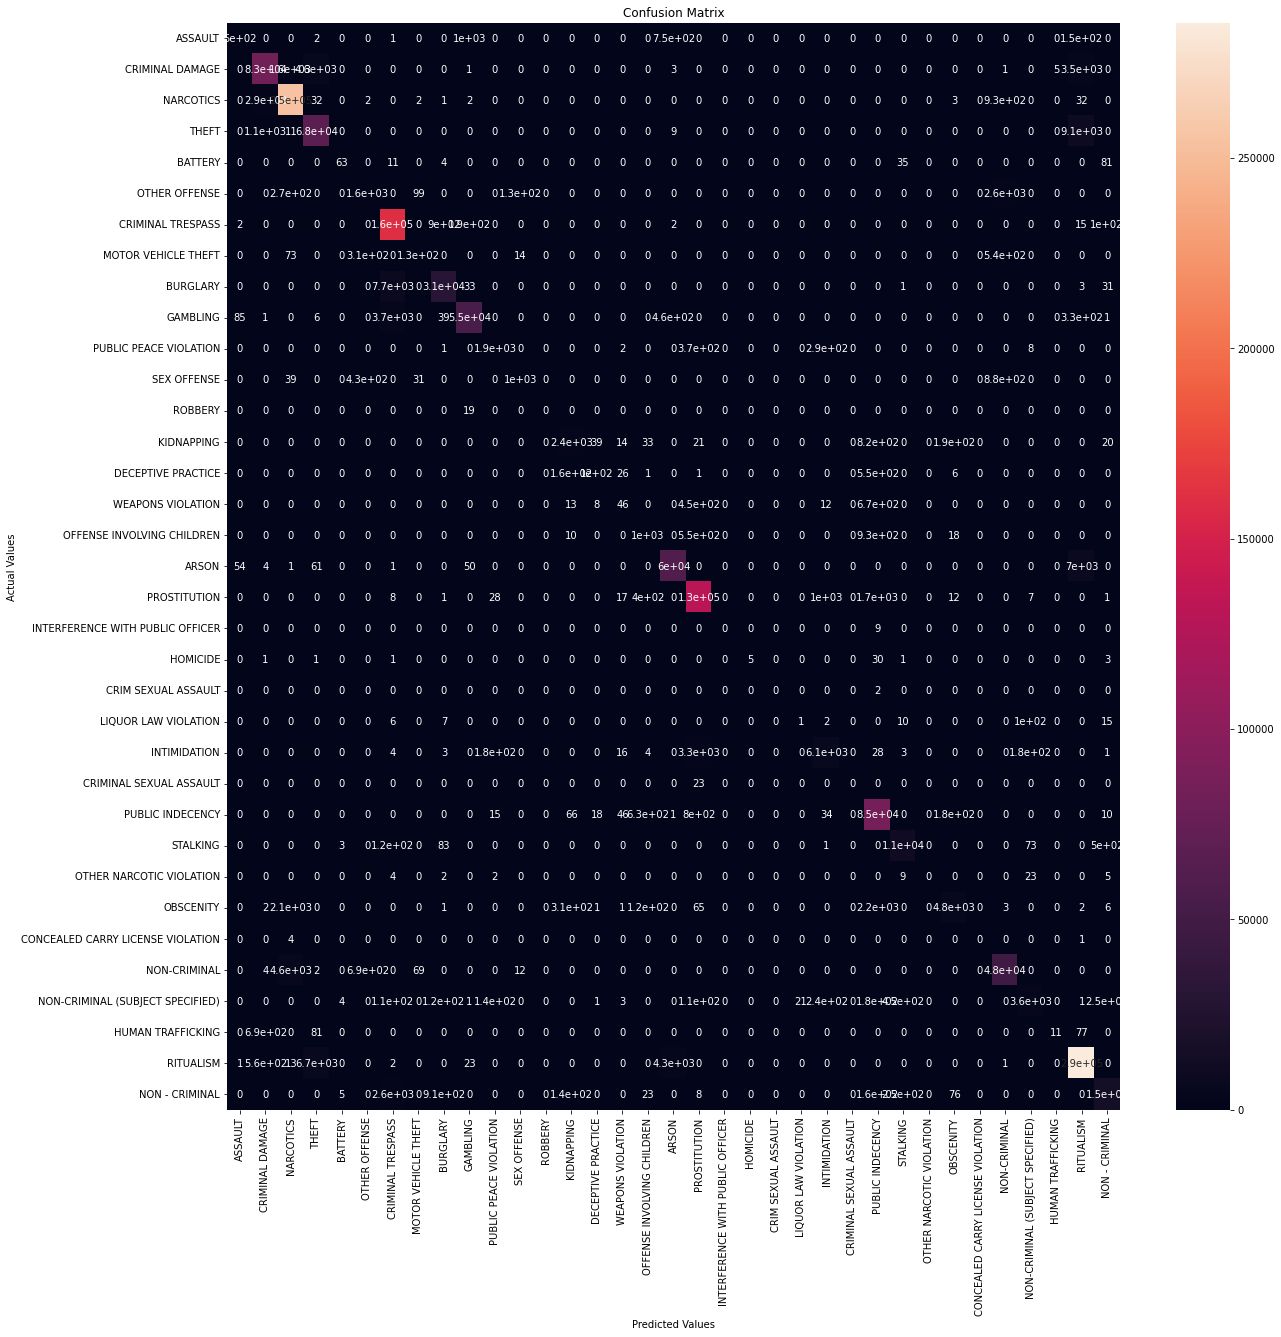

In [19]:
#plotting the confusion matrix
#confusion_matrix_1st_Try=multilabel_confusion_matrix(y_test,y_pred,labels=y_test.unique())
#confusion_matrix_1st_Try
# Creating  a confusion matrix,which compares the y_test and y_pred
cm1 = confusion_matrix(y_test, y_pred)
# Creating a dataframe for a array-formatted Confusion matrix,so it will be easy for plotting.
cm1_df = pd.DataFrame(cm1,
                     index = y_test.unique(), 
                     columns = y_test.unique())
#Plotting the confusion matrix
plt.figure(figsize=(20,20))
sns.heatmap(cm1_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

In [20]:
#Some tuning
#Scaling X
scaler=StandardScaler()
x_train_scaled=pd.DataFrame(scaler.fit_transform(x_train))
x_test_scaled=pd.DataFrame(scaler.fit_transform(x_test))

In [21]:
x_train_scaled

,0,1,2,3,4,5,6,7,8,9,10
0,-0.592526,-0.403395,0.485486,0.380329,-0.580873,0.484116,-1.500411,0.649019,-1.530338,-0.772113,-0.444707
1,-0.592526,-0.403395,0.484062,0.452569,-0.580873,0.360365,-1.487131,0.697225,0.702385,-0.464606,-0.558526
2,-0.592526,-0.403395,-0.101195,0.308090,-0.673775,0.675159,-0.894792,0.777568,-1.085542,-1.387127,-1.241436
3,-0.592526,-0.403395,0.754619,1.174968,-1.091835,1.453231,-0.865382,0.697225,0.467735,1.841695,-0.979654
4,1.687689,-0.403395,-0.925680,-0.992229,0.719756,-1.781045,0.795309,0.777568,1.630963,1.995448,2.901552
...,...,...,...,...,...,...,...,...,...,...,...
5621796,-0.592526,-0.403395,0.340240,0.886009,-0.720226,0.820916,-0.418451,0.006276,-0.749600,-1.387127,-1.241436
5621797,1.687689,-0.403395,-0.242169,0.091370,-0.395069,0.162779,-0.997370,0.327648,-0.732748,0.765421,0.579658
5621798,1.687689,-0.403395,0.355904,-1.570148,-0.720226,0.972005,-0.172749,-0.925702,-0.426410,-0.772113,-0.353653
5621799,-0.592526,2.478957,-0.655124,-1.208949,1.462973,-0.805109,0.706129,-1.954092,1.071302,1.995448,2.082060


In [ ]:
#Training the model 2nd Try
KnnmodelScaled=KNeighborsClassifier()
KnnmodelScaled.fit(x_train_scaled,y_train)
y_pred_scaled=KnnmodelScaled.predict(x_test_scaled)
print(accuracy_score(y_test,y_pred_scaled))

In [ ]:
#validation curve
k = np.arange(1, 20)
train_score, val_score = validation_curve(estimator=KNeighborsClassifier(), X=x_train_scaled, y=y_train, param_name='n_neighbors', param_range=k)

In [ ]:
#visualize the best k for n_neighbors
plt.plot(k,val_score.mean(axis=1), label='validation')
plt.plot(k,train_score.mean(axis=1), label='train')
plt.ylabel('score')
plt.xlabel('n_neighbors')
plt.legend()

In [ ]:
#Tuning the hyper Parameters
param_grid = {'n_neighbors': np.arange(1,20),'metric':['euclidean', 'manhattan']}
grid = GridSearchCV(KNeighborsClassifier(), param_grid)
grid.fit(x_train_scaled, y_train)

print(grid.best_params_) # Best parameters apparently
modelknngrid = grid.best_estimator_ #put parameters into model
modelknngrid.score(x_test_scaled,y_test) # score the model

We probably have too much features for a KNN model as it doesn't do well with high dimensionnality

### Removing the IUCR code and the FBI code

In [ ]:
df_NO_FBI_IUCR=df_ccr.drop(columns=['FBI Code_CODE','IUCR_CODE'])

In [ ]:
X2=df_NO_FBI_IUCR.drop(columns=['Primary Type'])
Y2=df_NO_FBI_IUCR['Primary Type']

x2_train,x2_test,y2_train,y2_test=train_test_split(X2,Y2,test_size=0.2,random_state=117)

In [ ]:
#Scaling X2
x2_train_scaled=pd.DataFrame(scaler.fit_transform(x2_train))
x2_test_scaled=pd.DataFrame(scaler.fit_transform(x2_test))

In [ ]:
#Training the models with and without scaling
#unscaled
KnnModel2=KNeighborsClassifier()
KnnModel2.fit(x2_train,y2_train)
y2_pred=KnnModel2.predict(x2_test)

#scaled

KnnModelScaled2=KNeighborsClassifier()
KnnModelScaled2.fit(x2_train_scaled,y2_train)
y2_pred_scaled=KnnModelScaled2.predict(x2_test_scaled)

print("accuracy score of unscaled result: ",accuracy_score(y2_test,y2_pred))
print("accuracy score of scaled result: ",accuracy_score(y2_test,y2_pred_scaled))

#### Well that sucks